# Introduction to DuckDB

Welcome to my brief and simple workshop on data transformation with DuckDB and Ray!  We're lightly sponsored by my employer, Quantum Signals, and by Databento, who have graciously provided some of the data we use.

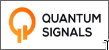
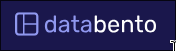

## Why SQL?  Isn't it ancient technology?

Since the Cambrian-like language explosion of recent years, it's worth wondering why we would even use a technology invented in the early 1970s (although LISP fans won't have such concerns for obvious reasons).  The short answer is that it's still around as ancient technology because it works; the longer answer is that it provides an excellent layer of abstraction.  If I can query a data source reliable with SQL, I don't care about what data source it is, and these "cut planes" allow sections of a codebase to evolve independently.

## Dude, where's my python?

It's coming.  I wanted to start with something language-agnostic.  For the moment, python is the language of choice for AI-related projects, but it is not the only one; as DuckDB and SQL can be used by different languages, I felt it important to show the capabilities outside of a standard programming language.

## Attributions

Much of the basic structure of this notebook comes from the JupySQL duckdb integration page (https://jupysql.ploomber.io/en/latest/integrations/duckdb.html) and other pages, rather lightly adapted because, frankly, I was short on time.  We'll try to use more relevant data in the next section.

# Your Workshop Needs More TLC

We'll start out by analyzing some data locally from the New York City Taxi and Limousine Commission (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).  This is one of many nice free datasets out there; you can retrieve a bit of it locally with the following code:


In [ ]:
from pathlib import Path
from urllib.request import urlretrieve

N_MONTHS = 3

# https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
for i in range(1, N_MONTHS + 1):
    filename = f"yellow_tripdata_2021-{str(i).zfill(2)}.parquet"
    if not Path(filename).is_file():
        print(f"Downloading: {filename}")
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{filename}"
        urlretrieve(url, filename)

These are only three parquet files, because we're only looking at three months, and they look pretty innocuous (22M-30M each).  But parquet can be deceiving.  How much would each one take up materialized in memory?

In [ ]:
import pandas as pd
df = pd.read_parquet("yellow_tripdata_2021-01.parquet")
df.info(memory_usage='deep')


So, rough order of magnitude this looks like about a 10x compression, and this is clearly a toy dataset for our purposes; if each month only materialized to 250Mb we could get about ten years of data into memory on a 32Gb machine without hitting virtual memory, but it's still worth playing with.  Let's see what we can learn without invoking more Python (directly).
First we'll create a table in our in-memory duckdb database.  In a regular database, this represents data stored within the database, and it does here too--it's just that the raw data is retrieved from the parquet files we provide.

In [ ]:
%load_ext sql
%sql duckdb://

In [ ]:
%%sql
CREATE OR REPLACE TABLE
  tlc AS
SELECT
  *
FROM
  read_parquet (["yellow*parquet"])

# Wut

If you haven't used SQL before, this looks a bit arcane; SQL is irritating in some ways because it relies on some convention (conventionally keywords are ALL CAPS but it's not necessary), mostly ignores whitespace, and can be oddly picky about quote marks and names.

It can also be quite dangerous in production.  A deep knowledge of SQL is a handy thing, and while LLMs can do a great job of basic stuff, the implications of some choices can be... less predictable.

This scrap of code does nothing more than create a "table" in our database consisting of all the data in all the parquet files we give it.  I've done this one as `CREATE OR REPLACE` so that the cell in the notebook can be re-run easily, but just `CREATE` would have worked.

# Querying our "Database"

We now have a virtual database, consisting of one table:

In [ ]:
%sqlcmd tables

# sqlcmd?

The "sql" and "sqlcmd" magic commands in jupysql do slightly different things.  `%%sql` executes an SQL query as if it were sent to the database; the `%sqlcmd` acts as if we were administrating the database itself.

...and we can thus examine the database as if it were an SQL-compatible database, even though we just have rough parquet files:

In [ ]:
%sqlcmd columns -t tlc

And, of course, query it using SQL just as if it were a database; we'll select three columns of five different rows to inspect some sample data:

In [ ]:
%%sql
SELECT tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count
FROM tlc
LIMIT 5


# Note

`LIMIT 5` does just what it says--limits the results to 5 rows.  Using `LIMIT` when exploring data is generally a very good idea; it makes the queries smaller and prevents your visual buffer from overflowing


So far, none of this looks particularly impressive.  What's interesting, however, is that we've interacted with our database in a unified manner without actually materializing any of the data into an in-memory table.

And that can be important, particularly for aggregate data.  The following query aggregates our TLC data by passenger count, getting us the number of trips by number of passengers, and the average length of those trips.  Doing this in pandas would require materialization of the whole dataframe and additional resources for the aggregation; using duckdb, we can get that information with very little code, and add further data sources as necessary.

The query is also quite efficient, as duckdb optimizes reads to the column-oriented parquet files

In [ ]:
%%sql
SELECT
    passenger_count, COUNT(*) as num_trips, AVG(trip_distance) AS avg_trip_distance
FROM "yellow_tripdata_2021-01.parquet"
GROUP BY passenger_count
ORDER BY passenger_count ASC

JupySQL's interface with duckdb doesn't just allow some transforms like this with memory efficiency--it also allows you to *plot* data with high efficiency.  Let's look at this with two different new concepts.

First we'll store an SQL query without actually executing the query, to give ourselves something to pull from later.  Second, we'll plot a histogram of trip distance, again without materializing the whole table at any point.

In [ ]:
%%sql --save histogram_base --no-execute
SELECT trip_distance
FROM tlc
WHERE trip_distance < 20

In [ ]:
%sqlplot histogram --table histogram_base --column trip_distance --bins 50

# Simple ETL/ELT

One of the most basic parts of any data pipeline is Extract/Transform/Load (although recently we're seeing variations like Extract/Load/Transform, where raw data is dumped into a "data lake" and transformed via SQL-style queries to produce data sets suitable for ML training)

DuckDB plays well with many ETL-related tools such as Dagster, Airflow, DBT, and more.  Here, let's look at a simple straightforward format for a data "pond" which covers a lot of use cases and scales very well up to a point: parquet files stored in hive partitions.

A single parquet file is easily queriable, as is many (hundreds).  But as the number of files goes up, the query performance goes down.  If you know what columns will form natural partitions (stock market queries by symbol, taxi rides by number of passengers, etc) you can choose a directory structure that encodes the column values in the directory names; this is called "hive" partitioning.

We can even do this transformation without any creation of tables, such as below, where we select a subset of data (vendor id, passenger count, trip distance, and total cost) and save to a set of parquet files partitioned by vendor id and passenger count:

In [ ]:
%%sql
COPY (SELECT
    VendorID, passenger_count, trip_distance, payment_type
    FROM read_parquet(["yellow*parquet"]))
    TO 'example_hive'
    (FORMAT 'parquet', COMPRESSION 'zstd',
    PARTITION_BY (VendorID, passenger_count)
    );


What did this do?  We can investigate the result with a bit of python:


In [ ]:
from pathlib import Path

def print_directory_contents(path, indent=""):
    p = Path(path)
    for item in p.iterdir():
        print(f"{indent}{item.name} ({item.stat().st_size} bytes)")
        if item.is_dir():
            print_directory_contents(item, indent + "  ")

print_directory_contents("./example_hive")


# Part 1 Conclusion

Nice!  You've learned about scanning external sources (parquet in this case, but CSV works too), querying via SQL, and transforming to hive-partitioned parquet.

Let's move on to using Python, the duckdb library, and "real" data stored in S3